#   Определение стратегии взаимодействия с клиентами фитнес-центров
**Описание проекта**   
Необходимо разработать стратегию взаимодействия с клиентами сети фитнес клубов на основе аналитических данных. 
Определить основные рекомендации по повышению качества работы с клиентами. 
____
 **Исходные данные:**  
 - файл, который содержит данные о клиентах на месяц до оттока и факт оттока на определённый месяц.
   
___
 **Цель проекта:**  
 - Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
 - Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
 - Сформулировать основные выводы и предложить рекомендации для стратегии взаимодействия с клиентами и их удержания.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Загрузка данных

In [2]:
gym_churn = pd.read_csv('gym_churn.csv')

In [3]:
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


**Описание данных**  

Данные клиента за предыдущий до проверки факта оттока месяц:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

# Исследовательский анализ данных (EDA)

## Посмотрим общую информацию

In [4]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

**Вывод**  

- В датафрейме 4000 строк и 14 колонок (13 признаков и целевая переменная); 
- Пропусков в данных нет; 
- Все переменные имеют числовой тип данных. Но есть и категориальные данные, только они уже преобразованы в числовые значения. 

## Посмотрим на статистики числовых переменных:

In [5]:
gym_churn.iloc[:, 0:9].describe() # выводим столбцы отдельно чтобы уместить по ширине страницы

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total
count,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59


In [6]:
gym_churn.iloc[:, 9:].describe()

,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.00,4000.00,4000.00,4000.00,4000.00
mean,4.32,3.72,1.88,1.77,0.27
std,4.19,3.75,0.97,1.05,0.44
min,1.00,0.00,0.00,0.00,0.00
25%,1.00,1.00,1.18,0.96,0.00
50%,1.00,3.00,1.83,1.72,0.00
75%,6.00,5.00,2.54,2.51,1.00
max,12.00,31.00,6.02,6.15,1.00


Почти половина признаков категориальные. Анамалий в переменных не наблюдается. Яркий выбросов тоже нет.    
Целевая переменная имеет среднее значение 0,27, то есть 27% значений имеет класс "1". Другими словами в датесете присутствует дисбаланс классов, при обучении модели это стоит учитывать.

In [7]:
gym_churn['Month_to_end_contract'] = gym_churn['Month_to_end_contract'].astype('int') # изменим тип на целочисленный

Подробнее посмотрим на средние значения признаков.

## Изучим средние значения признаков в двух группах (ушел/остался)

In [8]:
gym_mean = gym_churn.groupby('Churn').agg('mean')
gym_mean.rename(index={0:'stay',1:'gone'}, inplace=True)
gym_mean.T.style.format("{:.2f}").background_gradient(cmap='Blues', axis=1,high=0.8)

Churn,stay,gone
gender,0.51,0.51
Near_Location,0.87,0.77
Partner,0.53,0.36
Promo_friends,0.35,0.18
Phone,0.90,0.90
Contract_period,5.75,1.73
Group_visits,0.46,0.27
Age,29.98,26.99
Avg_additional_charges_total,158.45,115.08
Month_to_end_contract,5.28,1.66


По некоторым признакам средние значения сильно отличаются в зависимости от группы. А по некоторым почти не отличаются. Средние значения большинства признаков выше в группе клиентов, которые остались (`stay`).  
Здесь можно сделать первые предположения о влиянии признаков: Средняя частота посещения, Возраст, Срок абонемента, Время с 1-го посещения могут оказывать влияние на целевую переменную. Напротив признаки: Пол, Наличие контактного телефона и Близость фитнес клуба практические не оказывают влияние.

## Построим гистограммы и изучим распределения признаков в разрезе групп.

Разделим наши данные на признаки (матрица X) и целевую переменную (y)

In [9]:
X = gym_churn.drop('Churn', axis=1)
y = gym_churn['Churn']

Построим графики:

In [10]:
features=list(X.columns) #список признаков

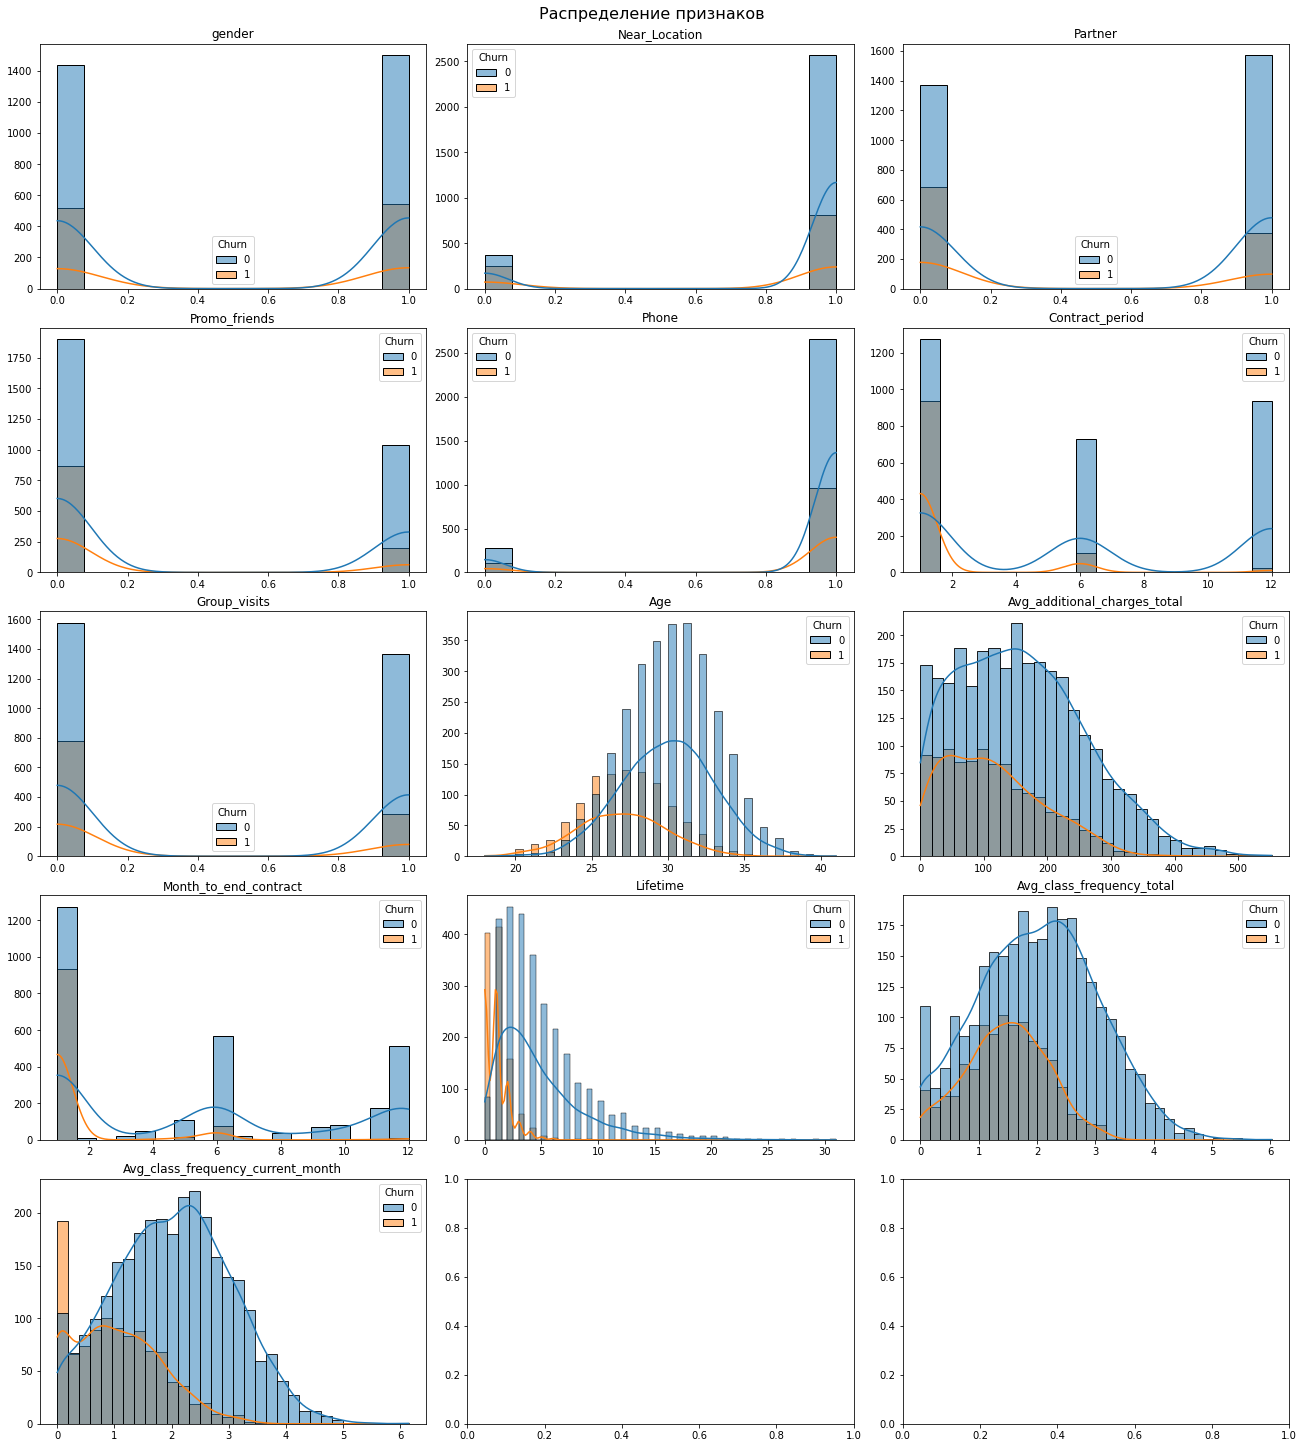

In [11]:
fig, axs = plt.subplots(5, 3, figsize=(18,20), constrained_layout=True, sharex=False, sharey=False)
fig.suptitle("Распределение признаков", fontsize=16)
for ax, feature in zip(axs.flat, features):
    sns.histplot(data=gym_churn, x=gym_churn[feature], hue='Churn', kde=True, ax=ax)
    ax.set_xlabel(None)
    ax.set_ylabel(None) 
    ax.set_title(feature)

Из всех числовых переменных нормальное распределение имеет, пожалуй, только возраст. И близко к нормальному распределению средняя частота посещений (за предыдущий месяц и за весь период). Кроме того очень схожее распределение двух признаков, средняя частота посещений за последний месяц и за весь период почти не отличаются. Также похожи признаки Срок абонемента и Срок до конца абонемента. 

Разница в распределении признака в зависимости от группы клиента(ушел/остался) наблюдается у признаков: Средняя частота посещения, Возраст, Срок абонемента, Время с 1-го посещения. Как и в случае сосредними значениями у признаки: Пол, Наличие контактного телефона и Близость фитнес клуба практические не наблюдается серьезной разницы в распределениях в зависимости от группы коиента (ушел/остался).

## Построим матрицу корреляций и heatmap.

In [12]:
cm = gym_churn.corr()
cm

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.00,0.01,-0.01,-0.01,-0.01,0.00,0.02,0.01,-0.01,-0.00,0.01,0.01,0.01,0.00
Near_Location,0.01,1.00,-0.01,0.21,-0.02,0.15,0.15,0.06,0.04,0.14,0.07,0.04,0.06,-0.13
Partner,-0.01,-0.01,1.00,0.45,0.01,0.31,0.02,0.05,0.02,0.29,0.06,0.02,0.05,-0.16
Promo_friends,-0.01,0.21,0.45,1.00,0.00,0.24,0.12,0.05,0.04,0.24,0.07,0.03,0.05,-0.16
Phone,-0.01,-0.02,0.01,0.00,1.00,-0.01,-0.01,-0.01,0.01,-0.01,-0.02,0.01,0.01,-0.00
Contract_period,0.00,0.15,0.31,0.24,-0.01,1.00,0.17,0.14,0.11,0.97,0.17,0.10,0.16,-0.39
Group_visits,0.02,0.15,0.02,0.12,-0.01,0.17,1.00,0.08,0.03,0.16,0.08,0.06,0.08,-0.18
Age,0.01,0.06,0.05,0.05,-0.01,0.14,0.08,1.00,0.08,0.13,0.16,0.12,0.18,-0.40
Avg_additional_charges_total,-0.01,0.04,0.02,0.04,0.01,0.11,0.03,0.08,1.00,0.11,0.08,0.04,0.08,-0.20
Month_to_end_contract,-0.00,0.14,0.29,0.24,-0.01,0.97,0.16,0.13,0.11,1.00,0.16,0.09,0.15,-0.38


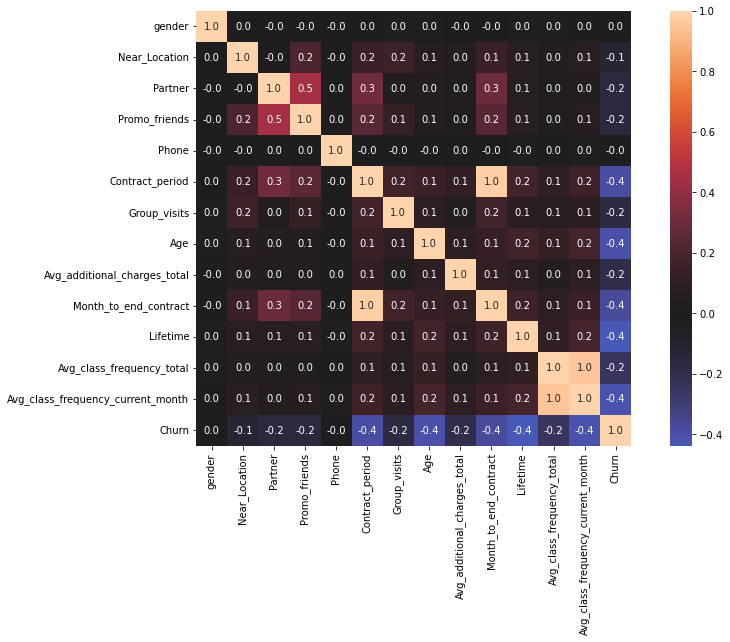

In [13]:
plt.figure(figsize=(14,8))
sns.heatmap(cm, annot=True, fmt='.1f', square=True, center=0);

Ни один признак не имеет сильной корреляции с целевой переменной. Как мы и предпологали более выраженное влияние (слабая корреляция) имеют признаки:
- Средняя частота посещения за предыдущий месяц; 
- Возраст; 
- Срок абонемента;
- Срок до окончания абонемента;
- Время с 1-го посещения.   

Остальные признаки имееют очень слабую корреляцию либо отстутсвие корреляции.

Сильно коррелируют между собой признаки Средняя частота посещения за предыдущий месяц и за весь период. А также признаки Срок абонемента и Срок до окончания абонемента. Большинство клиентов (больше половины) имеют месячный абонемент и срок окончания соответственно у большинства тоже месяц. Для линейных моделей взаимная корреляция нежелательна.  
В данном случае тот факт, что большинство клиентов имеют месячный абонемент влияет на взаимозависимость этих признаков. Возможно в будущем если доля клиентов с месячным абонементом будет уменьшаться, то признаки Средняя посещаемость в последний месяц и Срок до окончания абонемента смогут рассказать об оттоке чуть больше.   
Для построения модели регрегрессии удалим взаимозависимые признаки. Для модели Случайный лес мультиколлинеарность не повлияет на эффективность прогнозирования модели.  

# Построим модель прогнозирования оттока клиентов

Наша задача построить модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Для этого подойдут следующие алгоритмы: Логистическая регрессия, Случайный лес.  

Мы решаем задачу прогнозирования оттока на уровне конкретного клиента на горизонте следующего месяца. То есть наши наблюдения не складываются в последовательный временной ряд, поэтому будем использовать случайное разбиение выборки.

**Модель LogisticRegression**

In [14]:
X_part = gym_churn.drop(['Churn', 'Avg_class_frequency_total', 'Month_to_end_contract'], axis=1) #удаляем взаимозависимые признаки
y = gym_churn['Churn']

In [15]:
# разделяем модель на обучающую и валидационную выборку.
X_train, X_test, y_train, y_test = train_test_split(X_part, y, stratify=y, test_size=0.2, random_state=0)

In [16]:
# проведем стандартизацию для линейной модели
scaler = StandardScaler() 
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [17]:
model_lr = LogisticRegression(solver='liblinear', random_state=0)
model_lr.fit(X_train_st, y_train)

predictions_lr = model_lr.predict(X_test_st)
probabilities_lr = model_lr.predict_proba(X_test_st)[:, 1]

**Модель RandomForestClassifier**

In [18]:
X = gym_churn.drop('Churn', axis=1) # для модели Случайный лес будем использовать все признаки

In [19]:
# разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [20]:
model_rf = RandomForestClassifier(n_estimators = 100, random_state=0)
model_rf.fit(X_train, y_train)

predictions_rf = model_rf.predict(X_test)
probabilities_rf = model_rf.predict_proba(X_test)[:, 1]

**Выбор модели для прогнозирования**

In [21]:
print('Метрики для моделей:')
print(f"Логистическая регрессия - Accuracy:{accuracy_score(y_test, predictions_lr):.2f} Precision:{precision_score(y_test, predictions_lr):.2f} Recall:{recall_score(y_test, predictions_lr):.2f}")
print(f"          Случайный лес - Accuracy:{accuracy_score(y_test, predictions_rf):.2f} Precision:{precision_score(y_test, predictions_rf):.2f} Recall:{recall_score(y_test, predictions_rf):.2f}")

Метрики для моделей:
Логистическая регрессия - Accuracy:0.92 Precision:0.85 Recall:0.84
          Случайный лес - Accuracy:0.92 Precision:0.88 Recall:0.83


При данных параметрах чуть лучше метрики у модели Случайный лес. 

Метрики показываю не плохие результаты.   
Мы прогнозируем вероятность оттока клиента в следующем месяце. Нам не так страшно, если модель спрогнозирует факт оттока клиента, который на самом деле не хотел уходить, нежели если мы пропустим клиента, который действительно собирается уходить (для нас более негативный сценарий). Поэтому метрика `Recall` для нас более приоритетна. Попробуем сместить порог вероятности вниз. 

In [22]:
threshold = 0.3
custom_predictions = [0 if i < threshold else 1 for i in probabilities_rf]

In [23]:
print('Метрики для модели Случайный лес с заниженным порогом:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, custom_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, custom_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, custom_predictions)))

Метрики для модели Случайный лес с заниженным порогом:
Accuracy: 0.91
Precision: 0.77
Recall: 0.92


Как мы и хотели полнота прогноза повысилась. И естественно снизилась точность прогноза. Для нашей бизнес-задачи это более подходящие настройки. Мы можем более детально настроить полноту исходя из потребностей бизнеса.

**Посмотрим на важность признаков выбранной модели**

In [24]:
df = pd.DataFrame({"feature": list(X.columns), "feature_importances": list(model_rf.feature_importances_)})
df.sort_values('feature_importances',  ascending=False)

,feature,feature_importances
10,Lifetime,0.27
12,Avg_class_frequency_current_month,0.18
11,Avg_class_frequency_total,0.14
7,Age,0.12
8,Avg_additional_charges_total,0.09
9,Month_to_end_contract,0.07
5,Contract_period,0.07
6,Group_visits,0.02
0,gender,0.01
2,Partner,0.01


В целом все достаточно логично. Признаки Время с 1-го посещения, Средняя частота посещения за предыдущий месяц и за все время, Возраст имеют большее влияние на прогноз.

# Проведем кластеризацию клиентов

Проведем сегментацию клиентов. Выделим целевые группы клиентов с помощью алгоритма K-Means.  
Для начала оценим количество кластеров с помощью построения Дендограммы.

## Построим матрицу расстояний и Дендограмму

In [25]:
X_sc = scaler.fit_transform(X) # Стандартизируем наши исходные данные признаки (без столбца отток) 
linked = linkage(X_sc, method = 'ward') # Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков

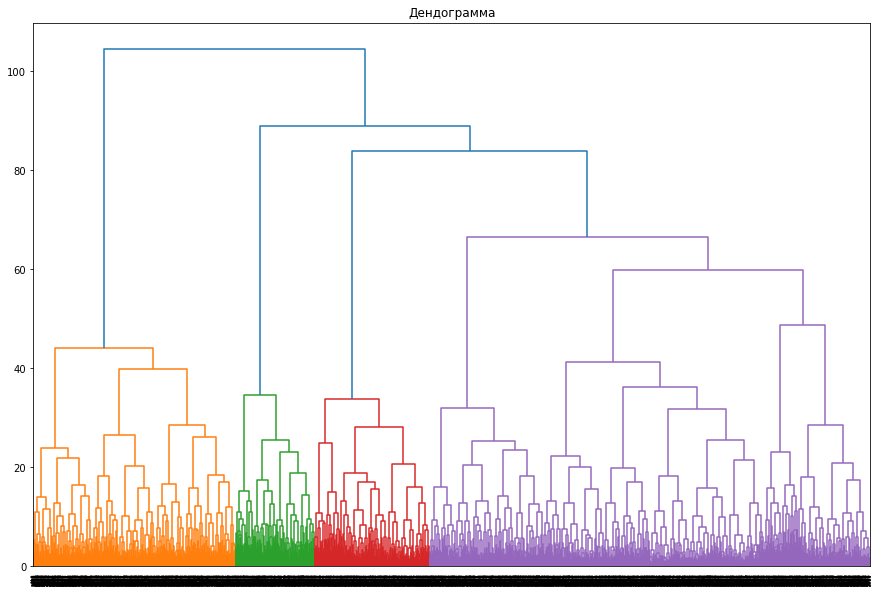

In [26]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top') #Построим Дендограмму
plt.title('Дендограмма')
plt.show()

Четыре разных цвета на графике. Можно выделить 4 кластера. По предварительной договоренности будем использовать 5 кластеров.

## Моделирование KMeans

In [27]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)

In [28]:
X['clusters'] = labels # сохраняем метки кластера в поле нашего датасета

## Оценим признаки распределенные по кластерам

**Посмотрим на средние значения признаков для кластеров**

In [29]:
mean_feature = X.groupby('clusters').agg('mean')
mean_feature.T.style.format("{:.2f}").background_gradient(cmap='Greens', axis=1, high=1)

clusters,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
Near_Location,0.96,0.86,0.00,1.00,0.98
Partner,0.78,0.47,0.46,0.35,0.36
Promo_friends,0.57,0.31,0.08,0.24,0.23
Phone,1.00,0.00,1.00,1.00,1.00
Contract_period,10.89,4.79,2.35,1.95,2.67
Group_visits,0.54,0.43,0.22,0.34,0.47
Age,29.98,29.30,28.48,28.17,30.13
Avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66
Month_to_end_contract,9.95,4.48,2.20,1.86,2.46


Мы видим что средние признаки для кластеров "0" и "4" выделяются. Также мы видим что средние значения отдельных признаков почти не меняются по кластерам.

**Построим распределения признаков для кластеров**

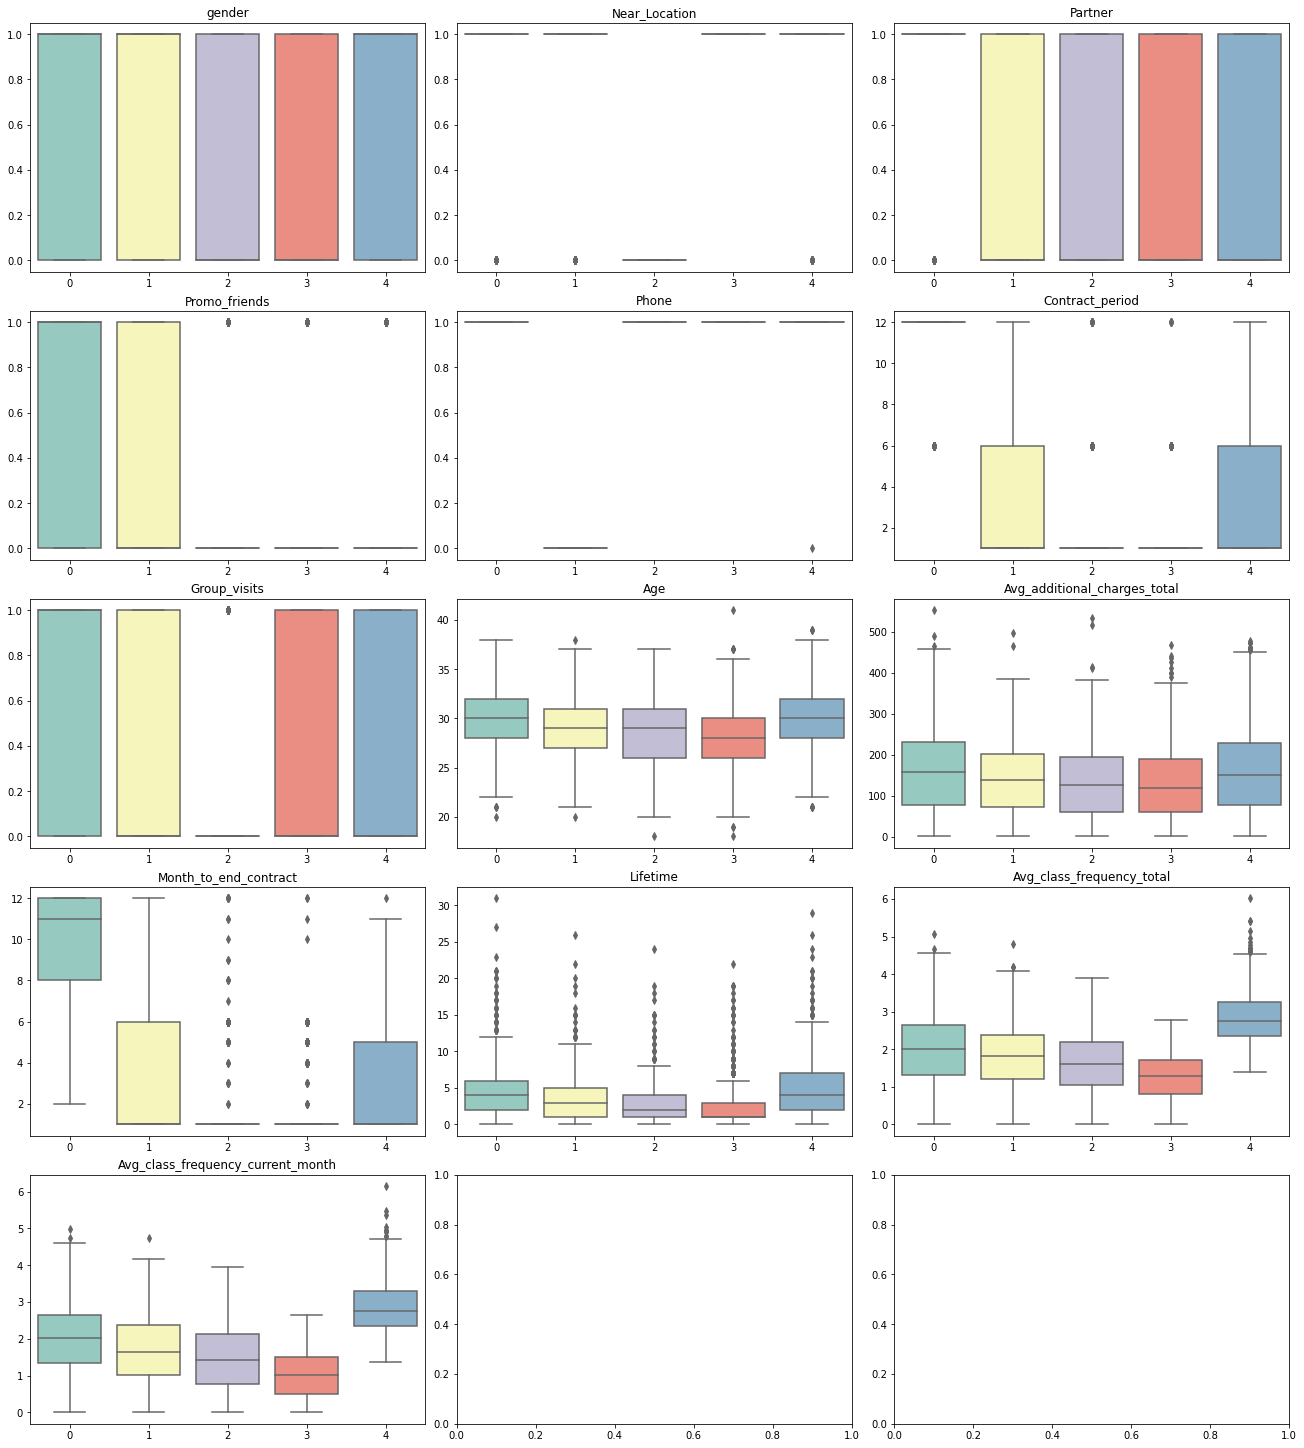

In [30]:
ig, axs = plt.subplots(5, 3, figsize=(18,20), constrained_layout=True, sharex=False, sharey=False)
fig.suptitle("Распределение признаков по кластерам", fontsize=16)
for ax, feature in zip(axs.flat, features):
    sns.boxplot(data=X, y=X[feature], x='clusters', palette="Set3", ax=ax)
    ax.set_xlabel(None)
    ax.set_ylabel(None) 
    ax.set_title(feature)

По распределению можно сделать такие же выводы как и после сравнения средних значений. Мы видим что для признаков Пол, Наличие контактного телефона, Близость фитнес клуба, Посещения групповых занятий распределения для большинства либо для всех кластеров не отличаются.  
А более разнообразные распределения по кластерам наблюдаются по признакам, которые оказывали более сильное влияние на прогноз оттока.

На основании данных распределений можно выделить группу клиентов (кластеры "0" и "4"). Этим клиентам как правило характерно:
- Раньше остальных начали посещать фитнес-клуб;
- Средняя посещаемость гораздо выше (больше 2-х раз в неделю);
- Они старше остальных клиентов( больше 30лет);
- В среднем больше тратят на прочие услуги фитнес-клуба;
- Срок абонемента чаще 6 или 12 месяцев.

Напротив, сегменты "3" и "2" не такие активные, это как правило новички, у них месячный абонемент и они как првило моложе.   
А сегмент "1" это что-то среднее между "3","2" и "0","4". Также клиенты сегмент "1" не оставляют номер телефона, тогда холодные продажи для них не подойдут.

Посмотрим на количество клиентов в сегментах.

In [31]:
X.groupby('clusters')['gender'].agg('count')

clusters
0    1010
1     385
2     505
3    1262
4     838
Name: gender, dtype: int64

Сегмент "1" не многочисленный. Основная часть клиентов распределена между сегментами  "3","2" и "0","4".

**Посчитаем долю оттока для каждого кластера**

In [32]:
gym_churn['clusters'] = labels
gym_churn.groupby('clusters')['Churn'].agg('mean').reset_index().rename(
    columns={'Churn': 'churn_share'}).sort_values('churn_share').style.format("{:.2%}", subset=['churn_share'])

,clusters,churn_share
0,0,2.77%
4,4,6.80%
1,1,26.75%
2,2,44.36%
3,3,51.43%


Доли оттока для кластеров "0" и "4" достаточно низкие (3% и 7% соответственно) по сравнению с другими кластерами. То есть эти группы пользователей более надежны в плане оттока. А клиенты кластеров "3" и "2" наоборот склонны к оттоку.

# Выводы и базовые рекомендации

Мы подобрали оптимальную модель для прогнозирования, которая с достаточно большой полнотой обнаруживает вероятности оттока клиента.  
Выделили основные сегменты клиентов и определили основные признаки влияющие на отток: Время с 1-го посещения, Средняя частота посещения за предыдущий месяц и за все время, Возраст, Выручка прочих услуг за все время посещения.

На основании проведенного анализа можно сформулировать следующие рекомендации:
- Больше всего доля оттока среди новичков, тех кто впервые купили месячный абонемент. Стоит более детально исследовать этот момент. Почему после пробного месяца они не остаются? Исследовать вовлеченность, удовлетворенность, процесс адаптации в фитнес-клубе;
- Стимулировать продажу более длительных абонементов (6, 12 мес). Скидки, дополнительные привелегии, выгоды для держателей таких абонементов;
- Клиенты после 30 лет меньше подвержены оттоку. При привлечении новых клиентов стоит больше ориенттироваться на людей возростной категории от 30 до 35 лет.